In [1]:
%matplotlib inline

# Steady-state visual evoked potential (SSVEP)

The SSVEP is a signal generated by repeatedly presenting a visual stimulus at a particular rate, so called because it involves the steady presentation of a stimulus and the response being one automatically generated (i.e. evoked) by a visual stimulus. 

In [10]:
# Imports
import os
from eegnb import generate_save_fn
from eegnb.devices.eeg import EEG
from eegnb.experiments.visual_ssvep import ssvep
#from eegnb.experiments.auditory_ssaep import ssaep_onefreq as ssaep

# Some standard pythonic imports
import os, numpy as np, pandas as pd
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.time_frequency import psd_welch,tfr_morlet

# EEG-Notebooks functions
from eegnb.analysis.utils2 import load_data,plot_conditions, check_report
from eegnb.datasets import fetch_dataset

### Experiment set-up

In [11]:
# Define some variables
board_name = "muse2_bfn"
experiment = "visual_ssvep"
subject_id = 0
session_nb = 0
record_duration = 120

After this set-up, we will want to make sure we're using the right inputs before starting the experiment. Here's one way of looking at the inputs, based on where our data will be saved:

In [12]:
eeg_device = EEG(device=board_name, serial_num='Muse-B00E')

# Create save file name
save_fn = generate_save_fn(board_name, experiment, subject_id, session_nb)
print(save_fn)

C:\Users\tchan3\.eegnb\data\auditory_ssaep\local\muse2_bfn\subject0000\session001\recording_2023-01-12-22.06.41.csv


If the subject and session are labeled with the right places, then that's where you'll find the data when the file is saved after the experiment runs. This is good to keep in mind for when you go find the data for analysis after.

Also, make sure you run the above cell once before every time you want to record the experiment. You'll see that the recording file name is time-stamped - if you don't run the cell again, you'll save over your old file with a new recording!

### Run experiment

Before starting an experiment, you want to make sure your data aren't too noisy. One way of doing this is to run a signal quality check:

In [5]:
check_report(eeg_device)



Running signal quality check...
Accepting threshold stdev between: 1 - 18
running check (up to) 60 times, with 5-second windows
will stop after 2 good check results in a row



1/60

Signal quality:
   Fp1: √  (std:   4.5)
   Fp2: √  (std:   6.9)
  TP10: √  (std:  15.5)
   TP9: √  (std:  14.5)
No bad channels



2/60

Signal quality:
   Fp1: √  (std:   5.0)
   Fp2: √  (std:   4.3)
  TP10: √  (std:   7.9)
   TP9: √  (std:   6.3)
No bad channels



All good! You can proceed on to data collection :) 


If you want to continue signal quality checks after the first 5, just hit ENTER. It'll continue to the next 5. To stop, press c before ENTER.

To start the experiment, just run the block of code below after running the previous blocks. 

In [13]:
ssvep.present(duration=record_duration, eeg=eeg_device, save_fn=save_fn)

463.2207 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [2048, 1152]. Using actual size
464.4021 	WARNING 	Use of rgb arguments to stimuli are deprecated. Please use color and colorSpace args instead
464.4203 	WARNING 	User requested fullscreen with size [1600  900], but screen is actually [2048, 1152]. Using actual size


If you are running the experiment multiple times, whether that's multiple sessions for a person or with different people, make sure that you are first running the previous cells where you change subject/session and also where the file is saved - otherwise, the files you generate will end up in the wrong folders!

### Visualize data

In [7]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    

# to load data from a specific subject and session:
subject = 0
session = 0
# make sure that these numbers are correct, or it will run from the last time you used 'subject' and 'session', 
# including from above!

raw = load_data(subject,session,
                experiment='visual_ssvep', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path)

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=28408
    Range : 0 ... 28407 =      0.000 ...   110.965 secs
Ready.


We're going to do a couple of things here that we won't go into now, but will help the final visual look like what it does above. We'll talk more about this process when we do the analyses!

In [8]:
# Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus.

events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}
epochs = Epochs(raw, events=events, event_id=event_id,
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=[0, 1, 2, 3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

37 events found
Event IDs: [1]
sample drop %:  5.405405405405405


We're looking for that sample drop % to be as low as possible. If yours is higher than 15%, check the raw number of trials that have come out. It could be that the original recording was a bit noisy, and that's okay.

Effective window size : 4.016 (s)


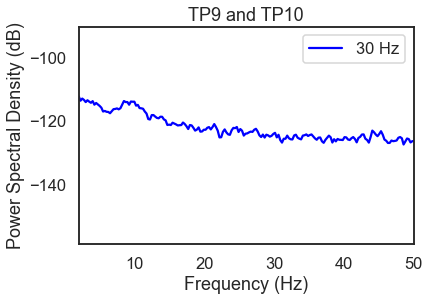

In [9]:
# Next, we can compare the PSD of epochs specifically during 20hz and 30hz stimulus presentation

f, ax = plt.subplots()
psd1, freq1 = psd_welch(epochs['30 Hz'], n_fft=1028, n_per_seg=256 * 3, picks='all')
psd2, freq2 = psd_welch(epochs['20 Hz'], n_fft=1028, n_per_seg=256 * 3, picks='all')
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)

psd2_mean = psd2.mean(0)

ax.plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='30 Hz')
ax.plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='20 Hz')

ax.set_title('TP9 and TP10')

ax.set_ylabel('Power Spectral Density (dB)')

ax.set_xlim((2, 50))

ax.set_xlabel('Frequency (Hz)')

ax.legend()

plt.show();

# With this visualization we can clearly see distinct peaks at 30hz and 20hz in the PSD, corresponding to the frequency of the visual stimulation. The peaks are much larger at the POz electrode, but still visible at TP9 and TP1

Your output should have some semblance of this:

![SSVEP](ssvep.png)

In [ ]:
# We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time

frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs['30 Hz'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=[0,3], baseline=(-0.5, -0.1), mode='logratio',
                 title='30 Hz stim');

tfr, itc = tfr_morlet(epochs['20 Hz'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=[0,3], baseline=(-0.5, -0.1), mode='logratio',
                 title='20 Hz stim');

plt.tight_layout()

# SSVEPs clearer with 20Hz than 30Hz